In [41]:
from pandas import read_csv, DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from seaborn import heatmap

import numpy as math
import matplotlib.pyplot as plot

scaler = StandardScaler()

In [69]:
X = read_csv('wino.csv')
y = X.pop('jakość')
K = X.columns
X = scaler.fit_transform(X)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

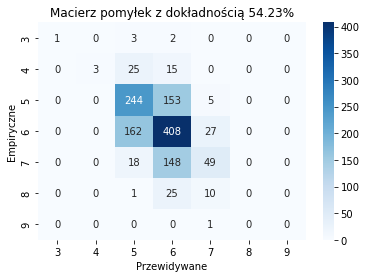

In [70]:
model = LogisticRegression(max_iter=200)
model.fit(X, y)                         # model osiąga zbieżność już przy 200 iteracjach

def confusion_matrix_plot(X_test, y_test, model, ax=None):
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    m = confusion_matrix(y_test, y_pred)
    m = DataFrame(m, index=model.classes_, columns=model.classes_)

    if ax is None:
        ax = plot.gca()

    heatmap(m, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Przewidywane')
    ax.set_ylabel('Empiryczne')
    ax.set_title('Macierz pomyłek z dokładnością {:.2%}'.format(score))

confusion_matrix_plot(X_test, y_test, model)

## Redukcja zmiennych

Do ulepszenia modelu można skorzystać z redukcji zmiennych, które są nieistotne, albo zaburzają model.

### Wskaźnik VIF

Współczynnik inflacji wariancji VIF wskazuje, że **gęstość** oraz zawartość **pozostałego cukru** mogą być współliniowe z pozostałymi zmiennymi - wartość współczynnika jest zbliżona albo większa od 10. Ich obecność w modelu może okazać się zbędna, ponieważ inne zmienne wystarczająco dobrze oddają ich wartość.

$$
\operatorname{VIF} = (1 - R_i^2)^{-1}
$$

$R_i$ - współczynnik determinacji uzyskany z regresji i-tej zmiennej na pozostałe zmienne niezależne.

Rozważane 2 modele - bez gęstości oraz bez gęstości i pozostałego cukru, chociaż prostsze, to są gorsze od modelu pełnego pod względem poprawności przewidywań.

In [28]:
def vif(X, K):
    f = DataFrame()
    f["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    f.index = K

    return f

vif(X, K)

,VIF
kwasowość,4.842130
lotna kwasowość,2.168158
kwas cytrynowy,1.629070
pozostały cukier,9.504990
wolne chlorki,1.672372
dwutlenek siarki,2.276663
dwutlenek siarki całkowity,4.140784
gęstość,21.441511
pH,2.488571
siarczany,1.560251


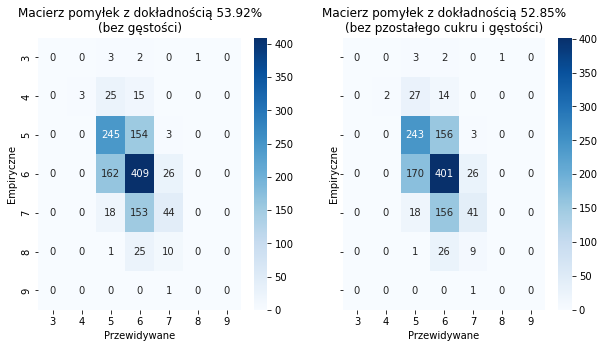

In [66]:
X = read_csv('wino.csv')
y = X.pop('jakość')

def reduced_model(X,y, remove):

    X = scaler.fit_transform(X.drop(columns=remove))
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=200)
    model.fit(X, y)

    return X_test, y_test, model

fix, axes = plot.subplots(1,2, figsize=(10,5), sharey=True)

confusion_matrix_plot(*reduced_model(X,y, remove = ['gęstość']), ax=axes[0])
axes[0].set_title(axes[0].get_title() + '\n(bez gęstości)');

confusion_matrix_plot(*reduced_model(X,y, remove = ['pozostały cukier', 'gęstość']), ax=axes[1])
axes[1].set_title(axes[1].get_title() + '\n(bez pzostałego cukru i gęstości)');

### Wysoka korelacja

Zmienne dotyczące dwutlenku siarki i SO2 całkowitego są bardzo silnie skorelowane i dotyczą podobnego zjawiska. Analiza dokładności model pozbawionego zmiennej SO2 pokazuje, że jest równie dokładny co model pełny stąd można podjąć decyzję o **usunięciu SO2 całkowitego** go ze zbioru badanych zmiennych. 

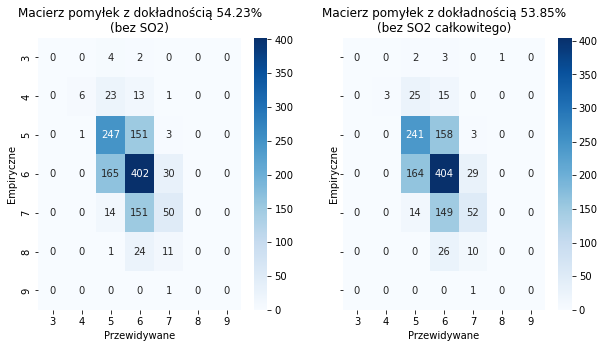

In [67]:
X = read_csv('wino.csv')
y = X.pop('jakość')

def reduced_model(X,y, remove):

    X = scaler.fit_transform(X.drop(columns=remove))
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=200)
    model.fit(X, y)

    return X_test, y_test, model

fix, axes = plot.subplots(1,2, figsize=(10,5), sharey=True)

confusion_matrix_plot(*reduced_model(X,y, remove = ['dwutlenek siarki']), ax=axes[0])
axes[0].set_title(axes[0].get_title() + '\n(bez SO2)');

confusion_matrix_plot(*reduced_model(X,y, remove = ['dwutlenek siarki całkowity']), ax=axes[1])
axes[1].set_title(axes[1].get_title() + '\n(bez SO2 całkowitego)');